# Принятие решений в бизнесе

Вместе с отделом маркетинга мы подготовили список гипотез для увеличения выручки. <br>
Приоритизируем гипотезы, запустим A/B-тест и проанализируем результаты.

В нашем распоряжении есть 3 датасета:
* "hypothesis", который содержит информацию о гипотизах
* "orders", в котором содержится информация о покупках
* "visitors", в котором собрана информация о посещениях


## Загрузим данные и подготовим их к анализу.

In [ ]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [ ]:
hypothesis, orders, visitors = (
    pd.read_csv('/datasets/hypothesis.csv'),
    pd.read_csv('/datasets/orders.csv'),
    pd.read_csv('/datasets/visitors.csv')
)

In [ ]:
for df in hypothesis, orders, visitors:
    df.info()
    print('duplicated sum:', df.duplicated().sum())
    print('---------------------------------------------------')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
duplicated sum: 0
---------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
duplicated sum: 0
-------------------

Видим что не все названия столбцов в змеином_регистре, по этому приведем их к единому стилю. <br>
Видим так же, что столбцы с датой в формате object. Переведем их в  datatime

In [ ]:
hypothesis.columns = hypothesis.columns.str.lower()
orders.rename(columns = {'transactionId' : 'transaction_id', 'visitorId' : 'visitor_id'}, inplace = True)

In [ ]:
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

In [ ]:
print('Дата начала теста:', orders['date'].min())
print('Дата окончания теста:', orders['date'].max())

Дата начала теста: 2019-08-01 00:00:00
Дата окончания теста: 2019-08-31 00:00:00


In [ ]:
visitors.groupby('group').agg({'visitors':'sum'})

,visitors
group,
A,18736
B,18916


In [ ]:
orders.groupby('group').agg({'transaction_id':'count'})

,transaction_id
group,
A,557
B,640


In [ ]:
orders.groupby('group').agg({'revenue':'mean'})

,revenue
group,
A,7333.578097
B,9230.875000


## Часть 1. Приоритизация гипотез.


### ICE

In [ ]:
hypothesis['ice'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
display(hypothesis[['hypothesis', 'ice']].sort_values('ice', ascending=False))

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день...",16.200000
0,"Добавить два новых канала привлечения трафика,...",13.333333
7,Добавить форму подписки на все основные страни...,11.200000
6,Показать на главной странице баннеры с актуаль...,8.000000
2,Добавить блоки рекомендаций товаров на сайт ин...,7.000000
1,"Запустить собственную службу доставки, что сок...",2.000000
5,"Добавить страницу отзывов клиентов о магазине,...",1.333333
3,"Изменить структура категорий, что увеличит кон...",1.125000
4,"Изменить цвет фона главной страницы, чтобы уве...",1.000000


#### Пояснение
После приоритезации гипотиз методом "ice" видим следующую картину: <br>
Гипотиза под номером 8, 0, 7 имеют патанцевал на дальнейшее исследование

### RICE

In [ ]:
hypothesis['rice'] = (
    hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
)
display(hypothesis[['hypothesis', 'rice']].sort_values('rice', ascending=False))

,hypothesis,rice
7,Добавить форму подписки на все основные страни...,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,56.0
0,"Добавить два новых канала привлечения трафика,...",40.0
6,Показать на главной странице баннеры с актуаль...,40.0
8,"Запустить акцию, дающую скидку на товар в день...",16.2
3,"Изменить структура категорий, что увеличит кон...",9.0
1,"Запустить собственную службу доставки, что сок...",4.0
5,"Добавить страницу отзывов клиентов о магазине,...",4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3.0


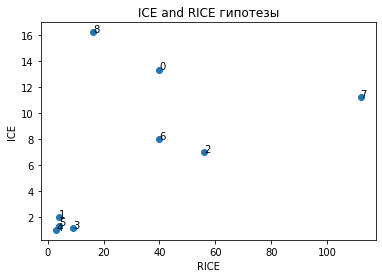

In [ ]:
y = hypothesis['ice']
z = hypothesis['rice']
n = hypothesis.index

fig, ax = plt.subplots()
ax.scatter(z, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i], y[i]))

plt.title("ICE and RICE гипотезы")
plt.xlabel("RICE")
plt.ylabel("ICE");

#### Пояснение
После приоритезации гипотиз методом "rice" видим следующую картину: <br>
Гипотиза под номером 7, 2, 0, 6 имеют патанцевал на дальнейшее исследование

### Выводы
После приоритезации методом rice появился вес у параметра "охват пользователей" что немаловажно. <br>
Гипотизы с небольшим охватом менее важны для бизнеса.

## Часть 2. Анализ A/B-теста


### Подготовим данные для исследования и построения графиков:

In [ ]:
# массив уникальных пар date и group
dates_groups = orders[['date','group']].drop_duplicates()

# агрегированные кумулятивные данные по дням
orders_aggregated = dates_groups.apply(
    lambda x: orders[np.logical_and(
        orders['date'] <= x['date'],
        orders['group'] == x['group']
    )].agg(
        {'date' : 'max',
         'group' : 'max',
         'transaction_id' : 'nunique',
         'visitor_id' : 'nunique',
         'revenue' : 'sum'}
    ), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина
visitors_aggregated = dates_groups.apply(
    lambda x: visitors[np.logical_and(
        visitors['date'] <= x['date'],
        visitors['group'] == x['group']
    )].agg(
        {'date' : 'max',
         'group' : 'max',
         'visitors' : 'sum'}
    ), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulative_data = orders_aggregated.merge(visitors_aggregated,
                                        left_on=['date', 'group'],
                                        right_on=['date', 'group'])

cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

In [ ]:
print(cumulative_data['date'].min())
print(cumulative_data['date'].max())

2019-08-01 00:00:00
2019-08-31 00:00:00


### Построим график кумулятивной выручки по группам

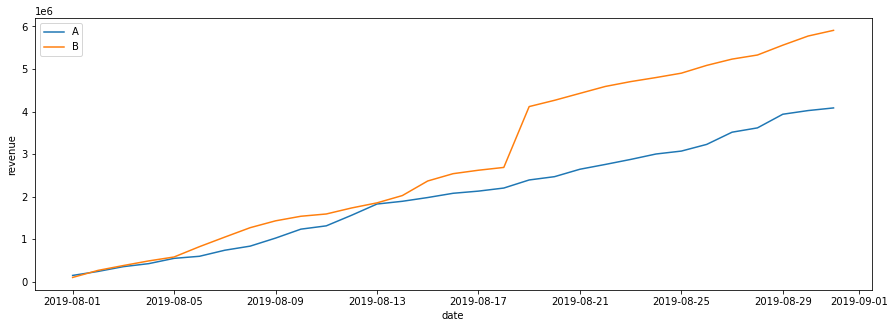

In [ ]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_a = cumulative_data.query('group == "A"')[['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_b = cumulative_data.query('group == "B"')[['date','revenue', 'orders']]

plt.figure(figsize=(15, 5))
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')
plt.legend()
plt.xlabel("date")
plt.ylabel("revenue");

#### Выводы
Мы видим что группа "B" на графике принесла больше выручки чем контрольная группа, так же мы видим у группы "B"
выраженный скачек 19.08, это скорее всего выбросы, будем проверять.

### Построим график кумулятивного среднего чека по группам

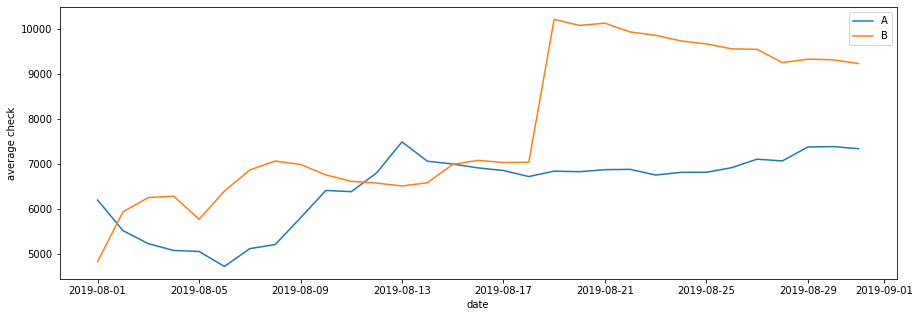

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(cumulative_revenue_a['date'],
         cumulative_revenue_a['revenue']/cumulative_revenue_a['orders'], label='A')
plt.plot(cumulative_revenue_b['date'],
         cumulative_revenue_b['revenue']/cumulative_revenue_b['orders'], label='B')
plt.legend()
plt.xlabel("date")
plt.ylabel("average check");

#### Выводы
Мы видим что у группы "B" на графике средний чек выше чем у контрольная группа, так же мы видим у группы "B"
выраженный скачек 19.08, это так же скорее всего выбросы.

### Построим график относительного изменения кумулятивного среднего чека группы B к группе A

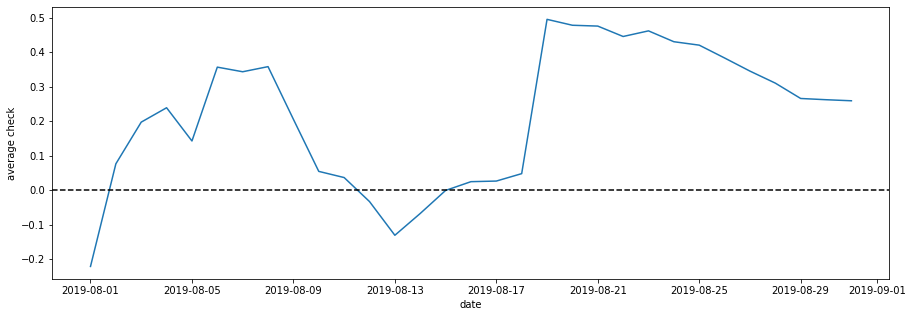

In [ ]:
# собираем данные в одном датафрейме
merged_cumulative_revenue = cumulative_revenue_a.merge(
    cumulative_revenue_b, left_on='date', right_on='date', how='left', suffixes=['_a', '_b'])

# cтроим отношение средних чеков
plt.figure(figsize=(15, 5))
plt.plot(merged_cumulative_revenue['date'],
         (merged_cumulative_revenue['revenue_b']/merged_cumulative_revenue['orders_b']) /
         (merged_cumulative_revenue['revenue_a']/merged_cumulative_revenue['orders_a'])-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel("date")
plt.ylabel("average check");

#### Выводы
Видим что средний чек группы "В" стабильно выше среднего чека контрольной группы. Но все так же видны выборсы.

### Построим график кумулятивной конверсии по группам

(18109.0, 18139.0, 0.02, 0.04)

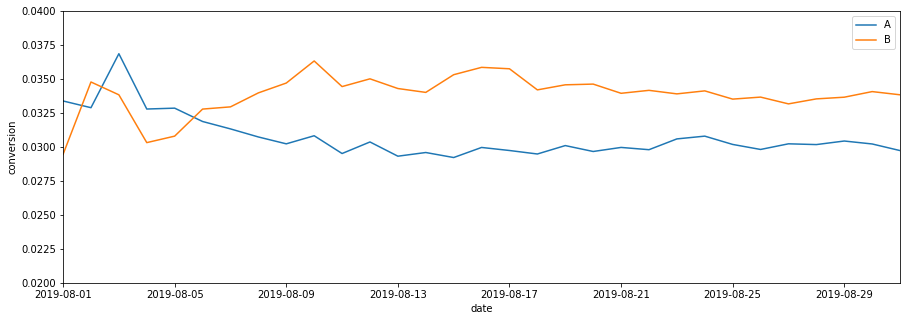

In [ ]:
# считаем кумулятивную конверсию
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']

# отделяем данные по группе A
cumulative_data_a = cumulative_data.query('group == "A"')

# отделяем данные по группе B
cumulative_data_b = cumulative_data.query('group == "B"')

# строим графики
plt.figure(figsize=(15, 5))
plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B')
plt.legend()
plt.xlabel("date")
plt.ylabel("conversion")

# задаем масштаб осей
plt.axis([cumulative_data['date'].min(), cumulative_data['date'].max(), 0.02, 0.04])

#### Выводы
Видем что у группы "В" конверсия значительно выше контрольной группы.

### Построим график относительного изменения кумулятивной конверсии группы B к группе A

(18109.0, 18139.0, -0.3, 0.3)

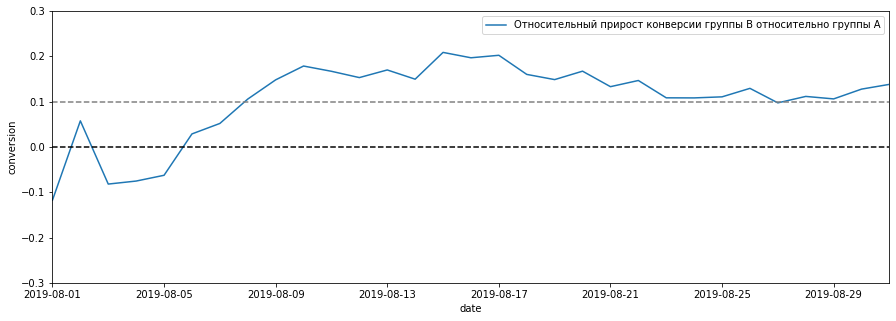

In [ ]:
merged_cumulative_conversions = cumulative_data_a[['date','conversion']].merge(
    cumulative_data_b[['date','conversion']],
    left_on='date', right_on='date', how='left', suffixes=['_a', '_b'])

plt.figure(figsize=(15, 5))
plt.plot(merged_cumulative_conversions['date'],
         merged_cumulative_conversions['conversion_b'] / merged_cumulative_conversions['conversion_a'] - 1,
         label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()
plt.xlabel("date")
plt.ylabel("conversion")

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.10, color='grey', linestyle='--')
plt.axis([cumulative_data['date'].min(), cumulative_data['date'].max(), -0.3, 0.3])

#### Выводы
Видим что группа "В" конверсируется лучше на 10%, чем контрольная группа

### Построим точечный график количества заказов по пользователям

In [ ]:
orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)

orders_by_users.columns = ['user_id', 'orders']

Text(0, 0.5, 'the number of orders')

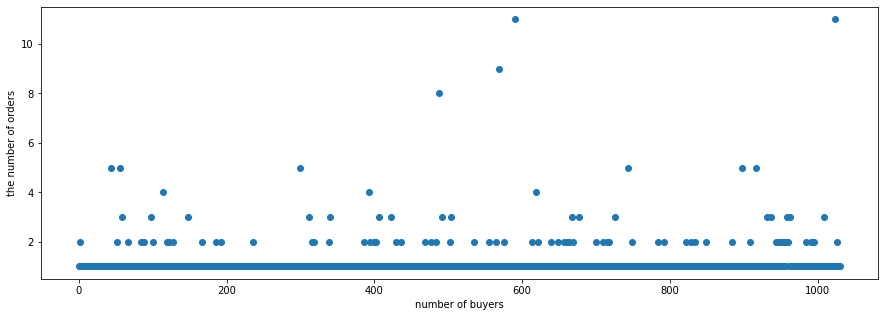

In [ ]:
x_values = pd.Series(range(0,len(orders_by_users)))

plt.figure(figsize=(15, 5))
plt.scatter(x_values, orders_by_users['orders'])
plt.xlabel("number of buyers")
plt.ylabel("the number of orders")

#### Выводы
На этом графике заменты выборсы, но не понятно что определить как грань по которой будем отсекать данные.

### Посчитаем 95-й и 99-й перцентили количества заказов на пользователя

In [ ]:
print(np.percentile(orders_by_users['orders'], [95, 99]))

[2. 4.]


#### Выводы
Больше 2 заказов на тело - определим как выборсы

### Построим точечный график стоимостей заказов

Text(0, 0.5, 'order cost')

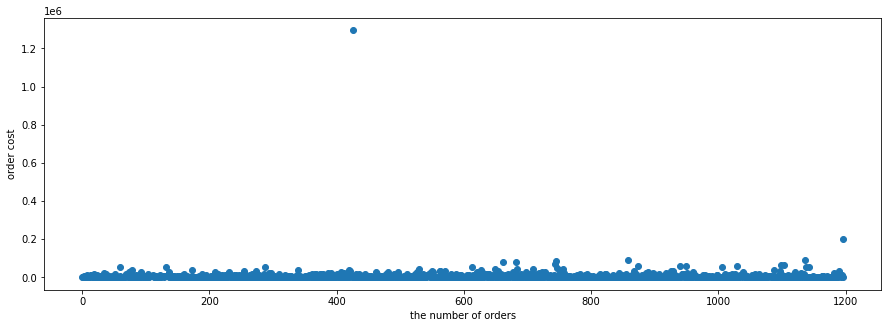

In [ ]:
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.figure(figsize=(15, 5))
plt.scatter(x_values, orders['revenue'])
plt.xlabel("the number of orders")
plt.ylabel("order cost")

(0.0, 120000.0)

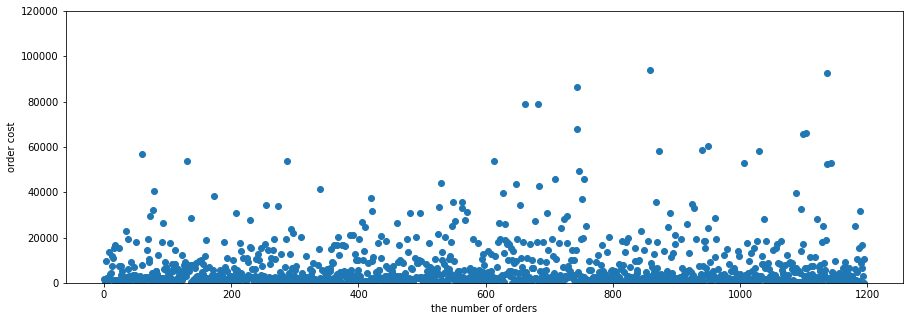

In [ ]:
plt.figure(figsize=(15, 5))
plt.scatter(x_values, orders['revenue'])
plt.xlabel("the number of orders")
plt.ylabel("order cost")
plt.ylim(bottom=0, top=120000)


#### Выводы
На этом графике заменты выборсы, но не понятно что определить как грань по которой будем отсекать данные.


### Посчитаем 95-й и 99-й перцентили стоимости заказов

In [ ]:
print(np.percentile(orders['revenue'], [95, 99]))

[28000.  58233.2]


#### Выводы
Больше 28 000 стоимость заказа - определим как выборсы

### Подготовим данные к расчету статистической значимости


In [ ]:
visitors_a_daily = visitors.query('group == "A"')[['date', 'visitors']]
visitors_a_daily.columns = ['date', 'visitors_per_date_a']

visitors_a_cummulative = visitors_a_daily.apply(
    lambda x: visitors_a_daily[visitors_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_a': 'sum'}
    ),
    axis=1,
)
visitors_a_cummulative.columns = ['date', 'visitors_cummulative_a']

visitors_b_daily = visitors.query('group == "B"')[['date', 'visitors']]
visitors_b_daily.columns = ['date', 'visitors_per_date_b']

visitors_b_cummulative = visitors_b_daily.apply(
    lambda x: visitors_b_daily[visitors_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_b': 'sum'}
    ),
    axis=1,
)
visitors_b_cummulative.columns = ['date', 'visitors_cummulative_b']

orders_a_daily = (
    orders.query('group == "A"')[['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)


orders_a_daily.columns = ['date', 'orders_per_date_a', 'revenue_per_date_a']


orders_a_cummulative = orders_a_daily.apply(
    lambda x: orders_a_daily[orders_a_daily['date'] <= x['date']].agg(
        {'date': 'max',
         'orders_per_date_a': 'sum',
         'revenue_per_date_a': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

orders_a_cummulative.columns = [
    'date',
    'orders_cummulative_a',
    'revenue_cummulative_a'
]

orders_b_daily = (
    orders.query('group == "B"')[['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_b_daily.columns = ['date', 'orders_per_date_b', 'revenue_per_date_b']

orders_b_cummulative = orders_b_daily.apply(
    lambda x: orders_b_daily[orders_b_daily['date'] <= x['date']].agg(
        {'date': 'max',
         'orders_per_date_b': 'sum',
         'revenue_per_date_b': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_b_cummulative.columns = [
    'date',
    'orders_cummulative_b',
    'revenue_cummulative_b'
]

data = (
    orders_a_daily.merge(
        orders_b_daily, left_on='date', right_on='date', how='left'
    )
    .merge(orders_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(orders_b_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_a_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_b_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_b_cummulative, left_on='date', right_on='date', how='left')
)

### Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным

Нулевая гиплотиза: статистически значимых различий в конверсии между группами нет <br>

In [ ]:
orders_by_users_a = (
    orders.query('group == "A"')
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)

orders_by_users_a.columns = ['visitor_id', 'orders']

orders_by_users_b = (
    orders.query('group == "B"')
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)

orders_by_users_b.columns = ['visitor_id', 'orders']

sample_a = pd.concat([orders_by_users_a['orders'], pd.Series(0, index=np.arange(
    data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])), name='orders')],axis=0)

sample_b = pd.concat([orders_by_users_b['orders'], pd.Series(0, index=np.arange(
    data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])), name='orders')],axis=0)


print('p-value = {0:.5f}'.format(stats.mannwhitneyu(sample_a, sample_b)[1]))

print('conversion = {0:.2}'.format(sample_b.mean() / sample_a.mean() - 1))


p-value = 0.01679
conversion = 0.14


#### Вывод:
По «сырым» данным различия в конверсии групп A и B есть. <br>
p-value = 0.017 меньше 0.05 Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет - отвергаем. <br>
Относительный прирост группы B равен 13.8% — второе число в выводе.

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.

Нулевая гиплотиза: статистически значимых различий в среднем чеке между группами нет <br>

In [ ]:
print('p-value = {0:.5f}'.format(stats.mannwhitneyu(
    orders.query('group == "A"')['revenue'], orders.query('group == "B"')['revenue'])[1]))

print('conversion = {0:.2}'.format(orders.query('group == "B"')['revenue'].mean() /
                       orders.query('group == "A"')['revenue'].mean()-1))


p-value = 0.72929
conversion = 0.26


#### Вывод:
P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. <br>
Однако средний чек группы B значительно выше среднего чека группы A.

### Отфильтруем данные

In [ ]:
revenu_max = np.percentile(orders['revenue'], [95, 99])[0]

users_with_many_orders = pd.concat(
    [
        orders_by_users_a.query('orders > 2')['visitor_id'],
        orders_by_users_b.query('orders > 2')['visitor_id'],
    ],
    axis=0,
)
users_with_expensive_orders = orders.query('revenue > @revenu_max')['visitor_id']
abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)

In [ ]:
sample_a_filtered = pd.concat(
    [
        orders_by_users_a[
            np.logical_not(orders_by_users_a['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b_filtered = pd.concat(
    [
        orders_by_users_b[
            np.logical_not(orders_by_users_b['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

### Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным.

Нулевая гиплотиза: статистически значимых различий в конверсии между группами нет <br>

In [ ]:
print('p-value = {0:.5f}'.format(stats.mannwhitneyu(sample_a_filtered,
                                          sample_b_filtered)[1]))

print('conversion = {0:.2}'.format(sample_b_filtered.mean() /
                       sample_a_filtered.mean()-1))

p-value = 0.01304
conversion = 0.17


#### Вывод:
По «очищенным» данным так же сохранились различия конверсии групп A и B. <br>
p-value = 0.013, еще меньше чем в "сырых" данных. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет - так же отвергаем. <br>
Относительный прирост группы B усилился и равен 17.3%

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

Нулевая гиплотиза: статистически значимых различий в среднем чеке между группами нет <br>

In [ ]:
print(
    'p-value = {0:.5f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    'conversion = {0:.2}'.format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1
    )
)

p-value = 0.73848
conversion = -0.02


#### Вывод:
P-value по прежнему значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, так же - нет. <br>
Однако средний чек группы B значительно снизился и стал даже ниже среднего чека группы A.

## Вывод

Гипотиза под номером 7, 2, 0, 6 имеют потенциал на дальнейшее исследование. <br>
A/B тест завершаем, есть положительны результат в конверсии группы B. <br>
Статистической значимости среднего чека тест не показал. <br>